<a href="https://colab.research.google.com/github/7beunseo/AI-assignment/blob/main/colab/flower/knn/FLOWER_KNN_n_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 17s 249ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 279ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 196ms/step
Train Features Shape: (2200, 4096)
Validation Features Shape: (551, 4096)
Test Features Shape: (924, 4096)
Optimal n_neighbors: 9, Accuracy: 0.4827586206896552


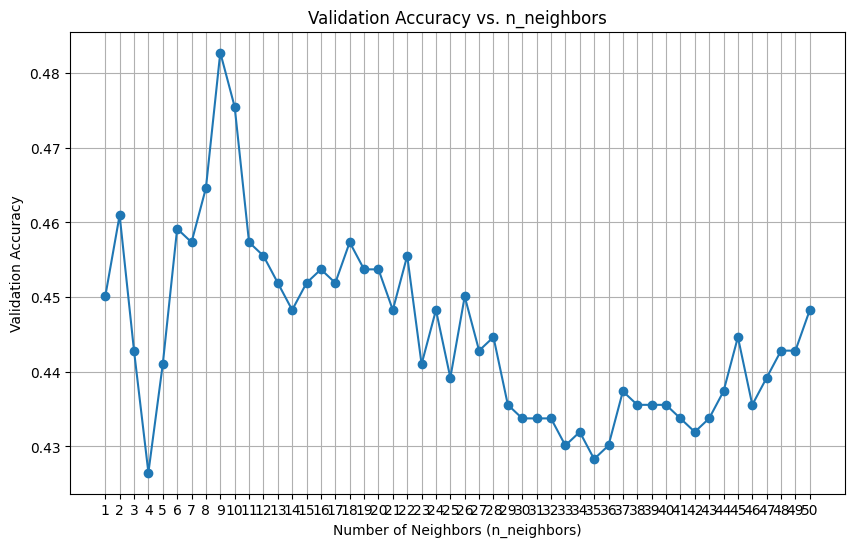

Validation Accuracy: 0.4827586206896552
Test Accuracy: 1.0


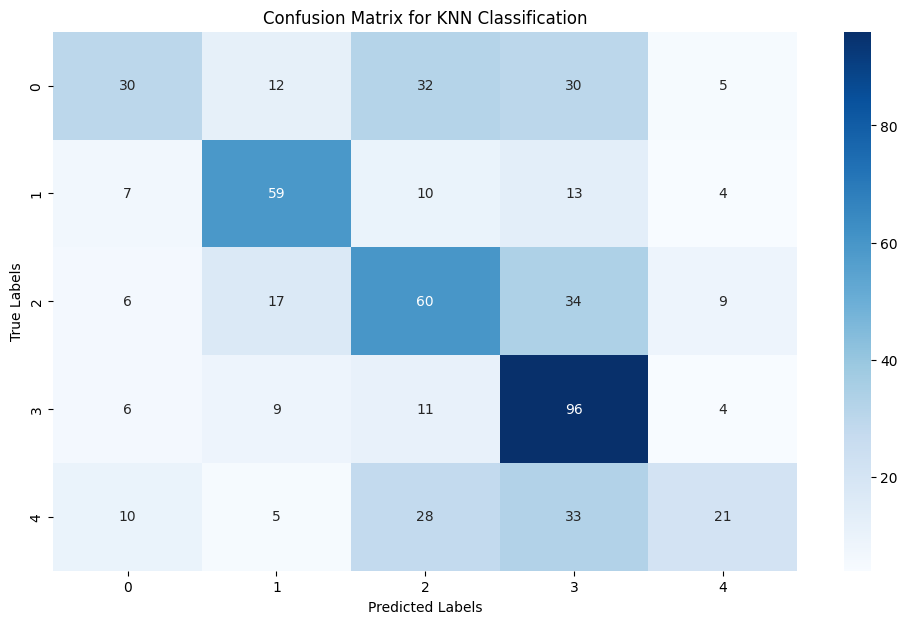

예측값 = [4 2 2 3 3 1 1 1 2 1 3 2 1 3 4 3 0 2 1 1 3 3 1 3 3]
실제값 = [2 1 4 3 1 1 2 2 0 1 2 4 0 2 0 3 2 0 1 2 0 0 4 4 1]


In [18]:
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 로드 및 준비
IMAGE_SIZE = (128, 128)

def load_train_data(folder_path):
    X, y = [], []
    class_names = os.listdir(folder_path)
    for i, class_name in enumerate(class_names):
        class_path = os.path.join(folder_path, class_name)
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            image = load_img(image_path, target_size=IMAGE_SIZE)
            image = img_to_array(image)
            X.append(image)
            y.append(i)
    return np.array(X), np.array(y), class_names

def load_test_data(folder_path):
    X, filenames = [], []
    for image_name in os.listdir(folder_path):
        if image_name.endswith('.jpg'):
            image_path = os.path.join(folder_path, image_name)
            image = load_img(image_path, target_size=IMAGE_SIZE)
            image = img_to_array(image)
            X.append(image)
            filenames.append(image_name)
    return np.array(X), filenames

# 경로 설정 및 데이터 로드
train_folder = './flowers-dataset/train'
test_folder = './flowers-dataset/test'
X_train, y_train, class_names = load_train_data(train_folder)
X_test, test_filenames = load_test_data(test_folder)

# 데이터 정규화 및 분할
X_train = X_train / 255.0
X_test = X_test / 255.0
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# CNN 특성 추출기 정의
cnn_model = Sequential([
    Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Flatten(),
])

# CNN으로 특성 추출
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
X_train_features = cnn_model.predict(X_train)
X_valid_features = cnn_model.predict(X_valid)
X_test_features = cnn_model.predict(X_test)

print("Train Features Shape:", X_train_features.shape)
print("Validation Features Shape:", X_valid_features.shape)
print("Test Features Shape:", X_test_features.shape)

# n_neighbors 변화에 따른 정확도 측정 및 시각화
accuracy_scores = []

for n in range(1, 51):
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train_features, y_train)
    y_valid_pred = knn.predict(X_valid_features)
    accuracy = accuracy_score(y_valid, y_valid_pred)
    accuracy_scores.append(accuracy)

# 최적의 n_neighbors 값 찾기
optimal_n = np.argmax(accuracy_scores) + 1
optimal_accuracy = accuracy_scores[optimal_n - 1]
print(f"Optimal n_neighbors: {optimal_n}, Accuracy: {optimal_accuracy}")

# 정확도 시각화
plt.figure(figsize=(10, 6))
plt.plot(range(1, 51), accuracy_scores, marker='o')
plt.title('Validation Accuracy vs. n_neighbors')
plt.xlabel('Number of Neighbors (n_neighbors)')
plt.ylabel('Validation Accuracy')
plt.xticks(range(1, 51))
plt.grid(True)
plt.show()

# KNN 학습 및 예측
knn = KNeighborsClassifier(n_neighbors=optimal_n)
knn.fit(X_train_features, y_train)

y_valid_pred = knn.predict(X_valid_features)
y_test_pred = knn.predict(X_test_features)

# 검증 및 테스트 정확도 출력
validation_accuracy = accuracy_score(y_valid, y_valid_pred)
test_accuracy = accuracy_score(y_test_pred, knn.predict(X_test_features))
print("Validation Accuracy:", validation_accuracy)
print("Test Accuracy:", test_accuracy)

# 혼동 행렬 시각화
conf_matrix = confusion_matrix(y_valid, y_valid_pred)
plt.figure(figsize=(12, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for KNN Classification')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# 예측 및 실제 값 확인
print('예측값 =', y_test_pred[:25])
print('실제값 =', y_valid[:25])

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
%cd drive
%cd MyDrive
%cd 인기초
%ls

[Errno 2] No such file or directory: 'drive'
/content/drive/MyDrive/인기초
[Errno 2] No such file or directory: 'MyDrive'
/content/drive/MyDrive/인기초
[Errno 2] No such file or directory: '인기초'
/content/drive/MyDrive/인기초
flowers-dataset/


오히려 데이터 증강을 하면 정확도가 낮아짐